### Chapter 11:  Deep Learning in Image Processing - Object Detection, and more

----

#### 1. Import thư viện và module cần thiết


In [1]:
# type: ignore
from keras.applications import VGG16 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from keras import models, layers, optimizers
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pylab as plt
from keras.preprocessing.image import load_img

vgg_conv = VGG16(weights='imagenet',
                include_top=False,
                input_shape=(224, 224, 3)) # it will download weights for the first time

Tải mô hình VGG16:
- VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) tải mô hình VGG16 với trọng số đã được huấn luyện trên tập dữ liệu ImageNet, nhưng không bao gồm phần lớp phân loại cuối (include_top=False). Kích thước đầu vào cho mô hình là (224, 224, 3), tương ứng với ảnh màu có kích thước 224x224.

Sử dụng mô hình VGG16 như một mạng đặc trưng (feature extractor):
- Mô hình VGG16 sẽ trích xuất các đặc trưng từ ảnh, và bạn có thể sử dụng nó như một bộ trích xuất đặc trưng cho các ảnh đầu vào mà không sử dụng phần phân lớp cuối.

Các thư viện khác:
- ImageDataGenerator được sử dụng để xử lý và tạo dữ liệu ảnh cho huấn luyện và xác thực.
- BatchNormalization là lớp dùng để chuẩn hóa các đầu vào trong quá trình huấn luyện mạng nơ-ron.
- load_img từ keras.preprocessing.image dùng để tải ảnh từ tệp.

#### 2. Thêm đầu vào và tiền xử lý dữ liệu

In [2]:
import numpy as np

train_dir = 'input/flower_photos/train'
validation_dir = 'input/flower_photos/valid'

nTrain = 500*5
nVal = 50*5

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 25
train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,5))

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

Found 2500 images belonging to 5 classes.


Khởi tạo thư mục dữ liệu:
- train_dir = 'input/flower_photos/train': Đường dẫn đến thư mục chứa ảnh huấn luyện.
- validation_dir = 'input/flower_photos/valid': Đường dẫn đến thư mục chứa ảnh xác thực.

Số lượng mẫu huấn luyện và xác thực:
- nTrain = 500 * 5: Tổng số mẫu huấn luyện (500 ảnh cho mỗi loại hoa, với 5 loại hoa).
- nVal = 50 * 5: Tổng số mẫu xác thực (50 ảnh cho mỗi loại hoa, với 5 loại hoa).

Tiền xử lý dữ liệu:
- datagen = ImageDataGenerator(rescale=1./255): Tạo một đối tượng ImageDataGenerator để xử lý dữ liệu, trong đó ảnh sẽ được chuẩn hóa (chia cho 255) để có giá trị pixel trong phạm vi [0, 1].

Khởi tạo mảng để lưu trữ đặc trưng và nhãn:
- train_features = np.zeros(shape=(nTrain, 7, 7, 512)): Mảng này sẽ lưu các đặc trưng trích xuất từ mô hình VGG16 cho mỗi ảnh huấn luyện (kích thước đặc trưng là 7x7x512).
- train_labels = np.zeros(shape=(nTrain, 5)): Mảng này sẽ lưu các nhãn của các ảnh huấn luyện, với mỗi nhãn có dạng one-hot encoding cho 5 lớp hoa.

Tạo generator để tải dữ liệu:
- train_generator = datagen.flow_from_directory(...): flow_from_directory tạo một generator để đọc ảnh từ thư mục train_dir, thay đổi kích thước ảnh thành (224, 224) và trả về các batch ảnh với kích thước batch_size = 25.
- class_mode='categorical': Chỉ ra rằng nhãn của ảnh là một dạng one-hot encoding (vì có 5 lớp hoa).
- shuffle=True: Sắp xếp lại các ảnh trong mỗi epoch để giảm sự thiên lệch trong huấn luyện.

#### 3. Trích xuất đặc trưng 

In [3]:
i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    #print(i * batch_size)
    if i * batch_size >= nTrain:
        break

train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

Duyệt qua các batch ảnh huấn luyện:
- for inputs_batch, labels_batch in train_generator: Lặp qua các batch dữ liệu huấn luyện từ train_generator. Mỗi batch gồm một tập các ảnh (inputs_batch) và các nhãn tương ứng (labels_batch).

Trích xuất đặc trưng từ ảnh:
- features_batch = vgg_conv.predict(inputs_batch): Dùng mô hình VGG16 (đã được tải trước) để trích xuất đặc trưng từ các ảnh trong batch hiện tại. Kết quả trả về là các đặc trưng (features) của ảnh, có kích thước (batch_size, 7, 7, 512).

Lưu trữ các đặc trưng và nhãn vào mảng:
- train_features[i * batch_size : (i + 1) * batch_size] = features_batch: Lưu các đặc trưng trích xuất được vào mảng train_features từ vị trí i * batch_size đến (i + 1) * batch_size.
- train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch: Lưu các nhãn vào mảng train_labels.

Kiểm tra điều kiện dừng:
- if i * batch_size >= nTrain: Kiểm tra nếu đã xử lý đủ số lượng ảnh huấn luyện (là nTrain ảnh).
- break: Nếu đã xử lý đủ, dừng vòng lặp.

Định dạng lại dữ liệu:
- train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512)): Sau khi trích xuất xong đặc trưng cho tất cả các ảnh huấn luyện, reshaped lại mảng train_features để có dạng (nTrain, 7 * 7 * 512), tức là mỗi đặc trưng được chuyển thành một vector có chiều dài 7 * 7 * 512.

#### 4, Trích xuất đặc trưng cho tập xác thực Validation

In [5]:
validation_features = np.zeros(shape=(nVal, 7, 7, 512))
validation_labels = np.zeros(shape=(nVal,5))

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)
i = 0
for inputs_batch, labels_batch in validation_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    validation_features[i * batch_size : (i + 1) * batch_size] = features_batch
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nVal:
        break
    
validation_features = np.reshape(validation_features, (nVal, 7 * 7 * 512))

Found 250 images belonging to 5 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Khởi tạo mảng đặc trưng và nhãn cho tập validation:
- validation_features = np.zeros(shape=(nVal, 7, 7, 512)): Tạo một mảng validation_features có kích thước (nVal, 7, 7, 512) để lưu trữ các đặc trưng trích xuất được từ các ảnh trong tập validation. - nVal là số lượng ảnh trong tập validation.
- validation_labels = np.zeros(shape=(nVal, 5)): Tạo mảng validation_labels có kích thước (nVal, 5) để lưu trữ các nhãn của tập validation. Giả sử có 5 lớp trong tập dữ liệu.

Tạo generator để load dữ liệu từ thư mục:
- validation_generator = datagen.flow_from_directory(...): Tạo một generator từ thư mục validation_dir với các tham số sau:
    - target_size=(224, 224): Mỗi ảnh sẽ được thay đổi kích thước thành 224x224 pixels.
    - batch_size=batch_size: Số lượng ảnh trong mỗi batch.
    - class_mode='categorical': Các nhãn sẽ được mã hóa dạng one-hot.
    - shuffle=False: Không xáo trộn dữ liệu trong tập validation.

Duyệt qua các batch ảnh trong tập validation:
- for inputs_batch, labels_batch in validation_generator: Duyệt qua các batch trong tập validation.
- features_batch = vgg_conv.predict(inputs_batch): Sử dụng mô hình VGG16 đã được tải trước để trích xuất đặc trưng từ các ảnh trong batch. Kết quả trả về là một mảng có kích thước (batch_size, 7, 7, 512).

Lưu trữ các đặc trưng và nhãn vào mảng:
- validation_features[i * batch_size : (i + 1) * batch_size] = features_batch: Lưu trữ các đặc trưng vào mảng validation_features từ vị trí i * batch_size đến (i + 1) * batch_size.
- validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch: Lưu trữ các nhãn vào mảng validation_labels.

Kiểm tra điều kiện dừng:
- if i * batch_size >= nVal: Kiểm tra nếu đã xử lý đủ số lượng ảnh trong tập validation (là nVal ảnh).
- break: Nếu đã xử lý đủ, dừng vòng lặp.

Định dạng lại mảng đặc trưng:
- validation_features = np.reshape(validation_features, (nVal, 7 * 7 * 512)): Định dạng lại mảng validation_features thành một vector có chiều dài 7 * 7 * 512 cho mỗi ảnh, từ đó tạo ra mảng có kích thước (nVal, 7 * 7 * 512).

#### 5. Xây dựng mô hình

In [6]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
#model.add(layers.Dense(256, activation='relu')) # make the neural network deep
#model.add(BatchNormalization())
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Khởi tạo mô hình Sequential:
- model = models.Sequential(): Tạo một mô hình tuần tự, nơi các lớp được thêm vào theo thứ tự.

Thêm lớp Dense đầu tiên:
- model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512)): Thêm một lớp Dense (fully connected layer) với 512 đơn vị (neurons).
- activation='relu': Sử dụng hàm kích hoạt ReLU (Rectified Linear Unit), giúp mô hình học tốt hơn bằng cách loại bỏ các giá trị âm.
- input_dim=7 * 7 * 512: Kích thước đầu vào của lớp này, tương ứng với số lượng đặc trưng đầu vào là 7 * 7 * 512, đây là số lượng đặc trưng sau khi trích xuất từ mô hình VGG16.

Thêm lớp BatchNormalization:
- model.add(BatchNormalization()): Thêm lớp chuẩn hóa theo batch (Batch Normalization) giúp tăng tốc độ huấn luyện và cải thiện hiệu quả của mô hình bằng cách chuẩn hóa đầu ra của các lớp.

Thêm lớp Dropout:
- model.add(layers.Dropout(0.5)): Thêm lớp Dropout để tránh hiện tượng overfitting (quá khớp) bằng cách ngẫu nhiên "bỏ qua" 50% (tỷ lệ dropout = 0.5) các kết nối trong quá trình huấn luyện.

Lớp Dense cuối cùng (Output Layer):
- model.add(layers.Dense(5, activation='softmax')): Lớp này là lớp đầu ra của mô hình với 5 đơn vị, tương ứng với 5 lớp (classes) mà mô hình dự đoán.
activation='softmax': Hàm kích hoạt softmax chuyển đổi đầu ra của lớp thành một xác suất, đảm bảo tổng các giá trị đầu ra là 1, phù hợp với bài toán phân loại đa lớp.

#### 6. Huấn luyện mô hình

In [7]:
from tensorflow.keras import optimizers

# Corrected code with 'learning_rate' argument
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),  # Use 'learning_rate' instead of 'lr'
                loss='categorical_crossentropy',
                metrics=['acc'])

history = model.fit(train_features,
                    train_labels,
                    epochs=10,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels))


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - acc: 0.5688 - loss: 1.3440 - val_acc: 0.7520 - val_loss: 0.7182
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - acc: 0.8676 - loss: 0.3805 - val_acc: 0.7840 - val_loss: 0.7152
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - acc: 0.9255 - loss: 0.2179 - val_acc: 0.7760 - val_loss: 0.8551
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - acc: 0.9719 - loss: 0.1170 - val_acc: 0.7960 - val_loss: 0.7795
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - acc: 0.9844 - loss: 0.0808 - val_acc: 0.7920 - val_loss: 0.8056
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - acc: 0.9776 - loss: 0.0757 - val_acc: 0.7960 - val_loss: 0.9352
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - acc: 0.9898 - loss: 0.0565 - val_acc: 0.8080 - val_loss: 0.8458
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - acc: 0.9957 - loss: 0.0369 - val_acc: 0.8000 - val_loss: 0.8785
Epoch 9/10
100/100 ━━━━━━━━━━━━━

Biên dịch mô hình (model.compile):
- optimizer=optimizers.Adam(learning_rate=1e-4): Mô hình sử dụng trình tối ưu hóa Adam với tốc độ học (learning_rate) là 1e-4. Adam là một thuật toán tối ưu hóa phổ biến vì tính ổn định và hiệu quả trong nhiều bài toán.
- loss='categorical_crossentropy': Hàm mất mát (loss function) được sử dụng là categorical_crossentropy, thích hợp cho bài toán phân loại đa lớp (multi-class classification).
- metrics=['acc']: Theo dõi độ chính xác (accuracy) trong quá trình huấn luyện để đánh giá hiệu suất mô hình.

Huấn luyện mô hình (model.fit):
- train_features: Đầu vào của mô hình trong quá trình huấn luyện, đây là các đặc trưng đã được trích xuất từ mô hình VGG16.
- train_labels: Nhãn (labels) tương ứng với các ảnh trong tập huấn luyện.
- epochs=10: Số lần lặp qua toàn bộ tập huấn luyện, trong trường hợp này là 10 lần.
- batch_size=batch_size: Kích thước của một lô (batch) dữ liệu được xử lý trong mỗi bước huấn luyện. Đây là tham số đã được định nghĩa trước là batch_size = 25.
- validation_data=(validation_features, validation_labels): Dữ liệu xác thực (validation) được sử dụng trong mỗi epoch để đánh giá mô hình sau khi huấn luyện.

In [8]:
print(f"Number of samples in validation set: {len(validation_generator)}")
print(f"Number of samples in validation features: {len(validation_features)}")


Number of samples in validation set: 10
Number of samples in validation features: 250


#### 7. Kiểm tra với tập dữ liệu Test

In [9]:
fnames = validation_generator.filenames 
ground_truth = validation_generator.classes 
label2index = validation_generator.class_indices 

idx2label = dict((v,k) for k,v in label2index.items()) 
prob = model.predict(validation_features)

predictions = np.argmax(prob, axis=1)
errors = np.where(predictions != ground_truth)[0]

# In ra số lượng lỗi
print("No of errors = {}/{}".format(len(errors), nVal))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
No of errors = 54/250


- fnames = validation_generator.filenames: Danh sách các tên tệp (filenames) của các ảnh trong tập xác thực.
- ground_truth = validation_generator.classes: Mảng chứa các nhãn thực tế (ground truth) cho các ảnh trong tập xác thực. Mỗi giá trị trong mảng là chỉ số lớp tương ứng với một ảnh.
- label2index = validation_generator.class_indices: Một từ điển ánh xạ giữa tên lớp và chỉ số lớp.
- idx2label = dict((v,k) for k,v in label2index.items()): Đảo ngược từ điển label2index để tạo ra một từ điển ánh xạ từ chỉ số lớp (index) về tên lớp (label).
- prob = model.predict(validation_features): Mô hình sẽ thực hiện dự đoán xác suất cho mỗi lớp (probability distribution) đối với mỗi ảnh trong tập xác thực. Kết quả là một mảng có kích thước (nVal, 5) (vì có 5 lớp).
- predictions = np.argmax(prob, axis=1): Lấy chỉ số lớp có xác suất cao nhất cho mỗi ảnh bằng cách sử dụng argmax theo chiều axis=1.
- Tính toán số lượng lỗi:
- errors = np.where(predictions != ground_truth)[0]: Tìm các chỉ số (indices) của các dự đoán không chính xác (nơi mà dự đoán không bằng nhãn thực tế).
- print("No of errors = {}/{}".format(len(errors), nVal)): In ra số lượng lỗi (số lượng dự đoán sai) trên tổng số ảnh trong tập xác thực.

In [10]:
label2index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [11]:
len(train_features), len(validation_features)

(2500, 250)

In [12]:
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

No of errors = 54/250


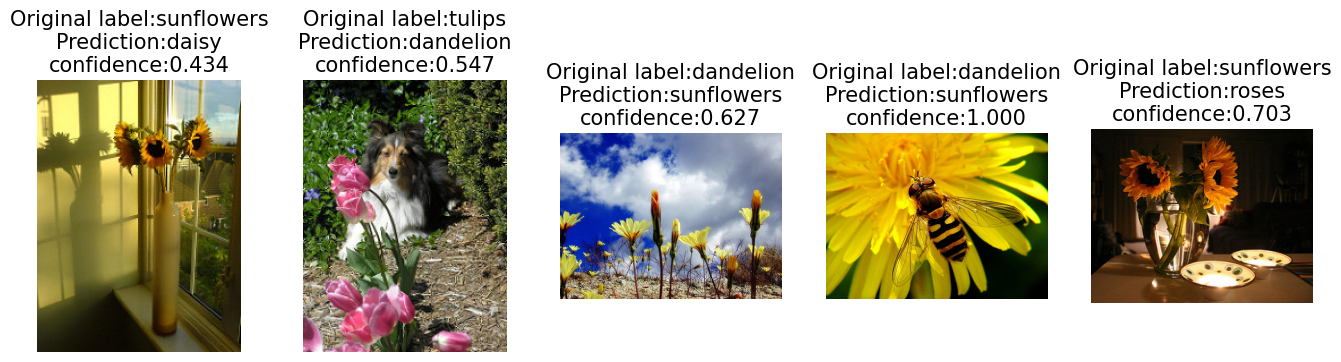

In [13]:
errors = np.random.choice(errors, 5)
plt.figure(figsize=(20,12))
for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.subplot(3,6,i+1), plt.imshow(original), plt.axis('off')
    plt.title('Original label:{}\nPrediction:{}\nconfidence:{:.3f}'.format(
        fnames[errors[i]].split('\\')[0],
        pred_label,
        prob[errors[i]][pred_class]), size=15)
plt.show()

- errors = np.random.choice(errors, 5): Lựa chọn ngẫu nhiên 5 lỗi (dự đoán sai) từ mảng errors. Các lỗi này là chỉ số của các ảnh mà mô hình dự đoán sai.
- plt.figure(figsize=(20,12)): Tạo một hình vẽ với kích thước 20x12 inch để hiển thị các ảnh.
- for i in range(len(errors)):: Lặp qua các lỗi đã chọn để hiển thị các ảnh tương ứng.
- pred_class = np.argmax(prob[errors[i]]): Lấy lớp dự đoán (class) có xác suất cao nhất từ mô hình cho ảnh lỗi.
- pred_label = idx2label[pred_class]: Lấy tên của lớp dự đoán từ từ điển idx2label.
- original = load_img('{}/{}'.format(validation_dir, fnames[errors[i]])): Tải ảnh gốc từ thư mục validation_dir sử dụng tên tệp từ fnames[errors[i]].
- plt.subplot(3,6,i+1), plt.imshow(original), plt.axis('off'): Hiển thị ảnh gốc trong hình vẽ, bỏ hiển thị trục tọa độ.
- plt.title('Original label:{}\nPrediction:{}\nconfidence:{:.3f}'.format(...)): Đặt tiêu đề cho mỗi ảnh hiển thị, bao gồm:
    - Original label: Nhãn thực tế của ảnh (lấy từ fnames[errors[i]]).
    - Prediction: Lớp dự đoán của mô hình.
    - Confidence: Độ tin cậy của dự đoán, là xác suất của lớp dự đoán (lấy từ prob[errors[i]][pred_class]).
- plt.show(): Hiển thị toàn bộ hình vẽ với các ảnh và thông tin dự đoán.